In [94]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay,
    accuracy_score, precision_score, recall_score, f1_score
)
from sklearn.feature_selection import RFECV

In [95]:
dfs = [pd.read_parquet('../Outputs/cleaned-5-player-features-camera-rounds.parquet'),
       pd.read_parquet('../Outputs/cleaned-5-player-features-3d-rounds.parquet'),
       pd.read_parquet('../Outputs/cleaned-5-player-features-camera-halves.parquet'),
       pd.read_parquet('../Outputs/cleaned-5-player-features-3d-halves.parquet')
       ]

In [96]:
# Add column for the number of seconds players are alive to rounds dfs
for i in range(5):
    dfs[0][f'p{i+1}_time_alive'] = (dfs[0][f'p{i+1}_num_samples_d'] + dfs[0][f'p{i+1}_num_samples_j']) / 2
    dfs[1][f'p{i+1}_time_alive'] = (dfs[1][f'p{i+1}_num_samples_d'] + dfs[1][f'p{i+1}_num_samples_j']) / 2

In [97]:
for df in dfs:
    print(df.head())

                                matchID     mapName side  roundNum  p1_name  \
0  035bfeb7-396b-4c48-b2aa-5f002c44b7c2  de_inferno   CT         1  Plopski   
1  035bfeb7-396b-4c48-b2aa-5f002c44b7c2  de_inferno   CT         4  Plopski   
2  035bfeb7-396b-4c48-b2aa-5f002c44b7c2  de_inferno   CT         5  Plopski   
3  035bfeb7-396b-4c48-b2aa-5f002c44b7c2  de_inferno   CT         7  Plopski   
4  035bfeb7-396b-4c48-b2aa-5f002c44b7c2  de_inferno   CT         8  Plopski   

  p2_name p3_name p4_name p5_name   p1_ch_area  ...  p5_alpha_d  \
0     REZ  es3tag  hampus    phzy  1145.626984  ...    0.366504   
1     REZ  es3tag  hampus    phzy  1299.840957  ...    0.109935   
2     REZ  es3tag  hampus    phzy  1412.352284  ...    0.047636   
3     REZ  es3tag  hampus    phzy  1157.643736  ...    1.000012   
4     REZ  es3tag  hampus    phzy   735.447172  ...    0.057844   

   p5_num_samples_d  p5_num_samples_j    p5_alpha_j          Label  \
0              36.0             184.0  2.571728e-01 

In [98]:
half_metrics = [
    'ch_area', 'ch_volume', 'ch_area_normed', 'ch_volume_normed',
    'frac_dim',
    'C1', 'C2', 'C3', 'C4', 'C5',
    'alpha_d', 'alpha_j', 'num_samples_d','num_samples_j',
]

round_metrics = half_metrics + ['time_alive']

# Statistic suffixes
stats = ['min', 'max', 'mean',  'std']

aggregate_dfs = []
for i in range(len(dfs)):
       if i <= 1:
              metrics = round_metrics
              # List comprehension for output column names
              output_columns = [f"{metric}_{stat}" for metric in metrics for stat in stats]

              # Iterate through each metric and calculate row-wise stats
              for metric in metrics:
                     cols = [f'p{i+1}_{metric}' for i in range(5)]

                     # Convert to a 2D array for row-wise operation
                     data = dfs[i][cols].to_numpy()

                     # Add new columns with row-wise aggregations
                     dfs[i][f'{metric}_min'] = np.min(data, axis=1)
                     dfs[i][f'{metric}_max'] = np.max(data, axis=1)
                     dfs[i][f'{metric}_mean'] = np.mean(data, axis=1)
                     dfs[i][f'{metric}_std'] = np.std(data, axis=1)
              aggregate_dfs.append(dfs[i][['matchID', 'mapName', 'side', 'roundNum', 'Label'] + output_columns])
       else:
              metrics = half_metrics
              # List comprehension for output column names
              output_columns = [f"{metric}_{stat}" for metric in metrics for stat in stats]

              # Iterate through each metric and calculate row-wise stats
              for metric in metrics:
                     cols = [f'p{i+1}_{metric}' for i in range(5)]

                     # Convert to a 2D array for row-wise operation
                     data = dfs[i][cols].to_numpy()

                     # Add new columns with row-wise aggregations
                     dfs[i][f'{metric}_min'] = np.min(data, axis=1)
                     dfs[i][f'{metric}_max'] = np.max(data, axis=1)
                     dfs[i][f'{metric}_mean'] = np.mean(data, axis=1)
                     dfs[i][f'{metric}_std'] = np.std(data, axis=1)
              aggregate_dfs.append(dfs[i][['matchID', 'mapName', 'side', 'team', 'Label'] + output_columns])

In [99]:
# Drop any rounds where a player was alive for less than 30 seconds in the rounds dfs
aggregate_dfs[0] = aggregate_dfs[0].loc[aggregate_dfs[0].time_alive_min >= 30]
aggregate_dfs[1] = aggregate_dfs[1].loc[aggregate_dfs[1].time_alive_min >= 30]

# Create the merged 3D and Camera Halves df as well
aggregate_dfs.append(pd.merge(aggregate_dfs[3], aggregate_dfs[2], on=['matchID', 'mapName', 'side', 'team', 'Label'], suffixes=('_3d', '_cam')))
aggregate_dfs.append(pd.merge(aggregate_dfs[1], aggregate_dfs[0], on=['matchID', 'mapName', 'side', 'roundNum', 'Label'], suffixes=('_3d', '_cam')))

In [100]:
# Make a dict
dfs_dict  = {'Camera Rounds': aggregate_dfs[0], '3D Rounds': aggregate_dfs[1], 'Camera Halves': aggregate_dfs[2], '3D Halves': aggregate_dfs[3], '3D & Camera Halves': aggregate_dfs[4], '3D & Camera Rounds': aggregate_dfs[5]}

In [101]:
# Dictionary of feature sets for various ablation studies
feature_sets = {
    "All": [
        'ch_area_min', 'ch_area_max', 'ch_area_mean', 'ch_area_std',
        'ch_volume_min', 'ch_volume_max', 'ch_volume_mean', 'ch_volume_std',
        'ch_area_normed_min', 'ch_area_normed_max', 'ch_area_normed_mean',
        'ch_area_normed_std', 'ch_volume_normed_min', 'ch_volume_normed_max',
        'ch_volume_normed_mean', 'ch_volume_normed_std', 'frac_dim_min',
        'frac_dim_max', 'frac_dim_mean', 'frac_dim_std', 'C1_min', 'C1_max',
        'C1_mean', 'C1_std', 'C2_min', 'C2_max', 'C2_mean', 'C2_std', 'C3_min',
        'C3_max', 'C3_mean', 'C3_std', 'C4_min', 'C4_max', 'C4_mean', 'C4_std',
        'C5_min', 'C5_max', 'C5_mean', 'C5_std', 'alpha_d_min', 'alpha_d_max',
        'alpha_d_mean', 'alpha_d_std', 'alpha_j_min', 'alpha_j_max',
        'alpha_j_mean', 'alpha_j_std'
    ],

    "No regular convex hull features": [
        'ch_area_normed_min', 'ch_area_normed_max', 'ch_area_normed_mean',
        'ch_area_normed_std', 'ch_volume_normed_min', 'ch_volume_normed_max',
        'ch_volume_normed_mean', 'ch_volume_normed_std', 'frac_dim_min',
        'frac_dim_max', 'frac_dim_mean', 'frac_dim_std', 'C1_min', 'C1_max',
        'C1_mean', 'C1_std', 'C2_min', 'C2_max', 'C2_mean', 'C2_std', 'C3_min',
        'C3_max', 'C3_mean', 'C3_std', 'C4_min', 'C4_max', 'C4_mean', 'C4_std',
        'C5_min', 'C5_max', 'C5_mean', 'C5_std', 'alpha_d_min', 'alpha_d_max',
        'alpha_d_mean', 'alpha_d_std', 'alpha_j_min', 'alpha_j_max',
        'alpha_j_mean', 'alpha_j_std'
    ],
    "Only regular convex hull features": [
        'ch_area_min', 'ch_area_max', 'ch_area_mean', 'ch_area_std',
        'ch_volume_min', 'ch_volume_max', 'ch_volume_mean', 'ch_volume_std'
    ],

    "No convex hull features at all": [
        'frac_dim_min', 'frac_dim_max', 'frac_dim_mean', 'frac_dim_std',
        'C1_min', 'C1_max', 'C1_mean', 'C1_std', 'C2_min', 'C2_max', 'C2_mean', 'C2_std',
        'C3_min', 'C3_max', 'C3_mean', 'C3_std', 'C4_min', 'C4_max', 'C4_mean', 'C4_std',
        'C5_min', 'C5_max', 'C5_mean', 'C5_std', 'alpha_d_min', 'alpha_d_max',
        'alpha_d_mean', 'alpha_d_std', 'alpha_j_min', 'alpha_j_max', 'alpha_j_mean', 'alpha_j_std'
    ],
    "Only convex hull features": [
        'ch_area_min', 'ch_area_max', 'ch_area_mean', 'ch_area_std',
        'ch_volume_min', 'ch_volume_max', 'ch_volume_mean', 'ch_volume_std',
        'ch_area_normed_min', 'ch_area_normed_max', 'ch_area_normed_mean',
        'ch_area_normed_std', 'ch_volume_normed_min', 'ch_volume_normed_max',
        'ch_volume_normed_mean', 'ch_volume_normed_std'
    ],

    "No normalized convex hull features": [
        'ch_area_min', 'ch_area_max', 'ch_area_mean', 'ch_area_std',
        'ch_volume_min', 'ch_volume_max', 'ch_volume_mean', 'ch_volume_std',
        'frac_dim_min', 'frac_dim_max', 'frac_dim_mean', 'frac_dim_std',
        'C1_min', 'C1_max', 'C1_mean', 'C1_std', 'C2_min', 'C2_max', 'C2_mean', 'C2_std',
        'C3_min', 'C3_max', 'C3_mean', 'C3_std', 'C4_min', 'C4_max', 'C4_mean', 'C4_std',
        'C5_min', 'C5_max', 'C5_mean', 'C5_std', 'alpha_d_min', 'alpha_d_max',
        'alpha_d_mean', 'alpha_d_std', 'alpha_j_min', 'alpha_j_max', 'alpha_j_mean', 'alpha_j_std'
    ],
    "Only normalized convex hull features": [
        'ch_area_normed_min', 'ch_area_normed_max', 'ch_area_normed_mean',
        'ch_area_normed_std', 'ch_volume_normed_min', 'ch_volume_normed_max',
        'ch_volume_normed_mean', 'ch_volume_normed_std'
    ],

    "No entropy constant features": [
        'ch_area_min', 'ch_area_max', 'ch_area_mean', 'ch_area_std',
        'ch_volume_min', 'ch_volume_max', 'ch_volume_mean', 'ch_volume_std',
        'ch_area_normed_min', 'ch_area_normed_max', 'ch_area_normed_mean',
        'ch_area_normed_std', 'ch_volume_normed_min', 'ch_volume_normed_max',
        'ch_volume_normed_mean', 'ch_volume_normed_std', 'frac_dim_min',
        'frac_dim_max', 'frac_dim_mean', 'frac_dim_std',
        'alpha_d_min', 'alpha_d_max', 'alpha_d_mean', 'alpha_d_std',
        'alpha_j_min', 'alpha_j_max', 'alpha_j_mean', 'alpha_j_std'
    ],
    "Only entropy constant features": [
        'C1_min', 'C1_max', 'C1_mean', 'C1_std', 'C2_min', 'C2_max', 'C2_mean', 'C2_std',
        'C3_min', 'C3_max', 'C3_mean', 'C3_std', 'C4_min', 'C4_max', 'C4_mean', 'C4_std',
        'C5_min', 'C5_max', 'C5_mean', 'C5_std'
    ],

    "No fractal dimension features": [
        'ch_area_min', 'ch_area_max', 'ch_area_mean', 'ch_area_std',
        'ch_volume_min', 'ch_volume_max', 'ch_volume_mean', 'ch_volume_std',
        'ch_area_normed_min', 'ch_area_normed_max', 'ch_area_normed_mean',
        'ch_area_normed_std', 'ch_volume_normed_min', 'ch_volume_normed_max',
        'ch_volume_normed_mean', 'ch_volume_normed_std', 'C1_min', 'C1_max',
        'C1_mean', 'C1_std', 'C2_min', 'C2_max', 'C2_mean', 'C2_std', 'C3_min',
        'C3_max', 'C3_mean', 'C3_std', 'C4_min', 'C4_max', 'C4_mean', 'C4_std',
        'C5_min', 'C5_max', 'C5_mean', 'C5_std', 'alpha_d_min', 'alpha_d_max',
        'alpha_d_mean', 'alpha_d_std', 'alpha_j_min', 'alpha_j_max',
        'alpha_j_mean', 'alpha_j_std'
    ],
    "Only fractal dimension features": [
        'frac_dim_min', 'frac_dim_max', 'frac_dim_mean', 'frac_dim_std'
    ],

    "No alpha features": [
        'ch_area_min', 'ch_area_max', 'ch_area_mean', 'ch_area_std',
        'ch_volume_min', 'ch_volume_max', 'ch_volume_mean', 'ch_volume_std',
        'ch_area_normed_min', 'ch_area_normed_max', 'ch_area_normed_mean',
        'ch_area_normed_std', 'ch_volume_normed_min', 'ch_volume_normed_max',
        'ch_volume_normed_mean', 'ch_volume_normed_std', 'frac_dim_min',
        'frac_dim_max', 'frac_dim_mean', 'frac_dim_std', 'C1_min', 'C1_max',
        'C1_mean', 'C1_std', 'C2_min', 'C2_max', 'C2_mean', 'C2_std', 'C3_min',
        'C3_max', 'C3_mean', 'C3_std', 'C4_min', 'C4_max', 'C4_mean', 'C4_std',
        'C5_min', 'C5_max', 'C5_mean', 'C5_std'
    ],
    "Only alpha features": [
        'alpha_d_min', 'alpha_d_max', 'alpha_d_mean', 'alpha_d_std',
        'alpha_j_min', 'alpha_j_max', 'alpha_j_mean', 'alpha_j_std'
    ]
}

In [102]:
test_df = dfs[3]

In [103]:
test_df.head()

,matchID,mapName,side,team,p1_name,p2_name,p3_name,p4_name,p5_name,p1_ch_area,...,alpha_j_mean,alpha_j_std,num_samples_d_min,num_samples_d_max,num_samples_d_mean,num_samples_d_std,num_samples_j_min,num_samples_j_max,num_samples_j_mean,num_samples_j_std
0,035bfeb7-396b-4c48-b2aa-5f002c44b7c2,de_inferno,CT,Ninjas in Pyjamas,Plopski,REZ,es3tag,hampus,phzy,1.432302e+07,...,0.317527,0.043436,183.0,569.0,417.2,138.003478,1604.0,2293.0,1834.6,249.620993
1,035bfeb7-396b-4c48-b2aa-5f002c44b7c2,de_inferno,T,G2 Esports,AmaNEk,JACKZ,NiKo,huNter-,kennyS,2.208576e+07,...,0.332791,0.055911,230.0,342.0,299.0,38.863865,1612.0,2016.0,1772.6,142.061395
2,046cdf91-97ab-4b8b-b19e-4c17ba3aa129,de_ancient,CT,Endpoint.CeX,CRUC1AL,MiGHTYMAX,Surreal,Thomas,mirbit,1.235731e+07,...,0.332393,0.036509,188.0,390.0,330.4,72.901577,1431.0,1935.0,1653.2,192.317862
3,046cdf91-97ab-4b8b-b19e-4c17ba3aa129,de_ancient,T,SINNERS Esports,NEOFRAG,SHOCK,ZEDKO,beastik,oskar,2.067009e+07,...,0.396627,0.065468,250.0,524.0,394.0,90.117701,1806.0,2130.0,1970.6,113.154054
4,0657c9fd-a475-4257-8879-265fdbfd59b0,de_mirage,CT,Natus Vincere,Boombl4,Perfecto,b1t,electronic,s1mple,8.731215e+06,...,0.370535,0.080800,191.0,708.0,416.0,167.161000,2033.0,2444.0,2293.8,144.121338


(422,) classes
(2471, 12) (2471,)
(618, 12) (618,)
Train Accuracy: 0.3209
Test Accuracy: 0.1214 | Precision: 0.1002 | Recall: 0.1214 | F1: 0.0995
             Feature  AvgAbsCoefficient
0     ch_area_normed           0.819922
1          ch_volume           0.790491
2            alpha_j           0.730454
3            ch_area           0.730431
4   ch_volume_normed           0.723724
5           frac_dim           0.634516
6                 C2           0.607489
7                 C3           0.607069
8                 C4           0.557393
9                 C5           0.537267
10                C1           0.362173
11           alpha_d           0.002350


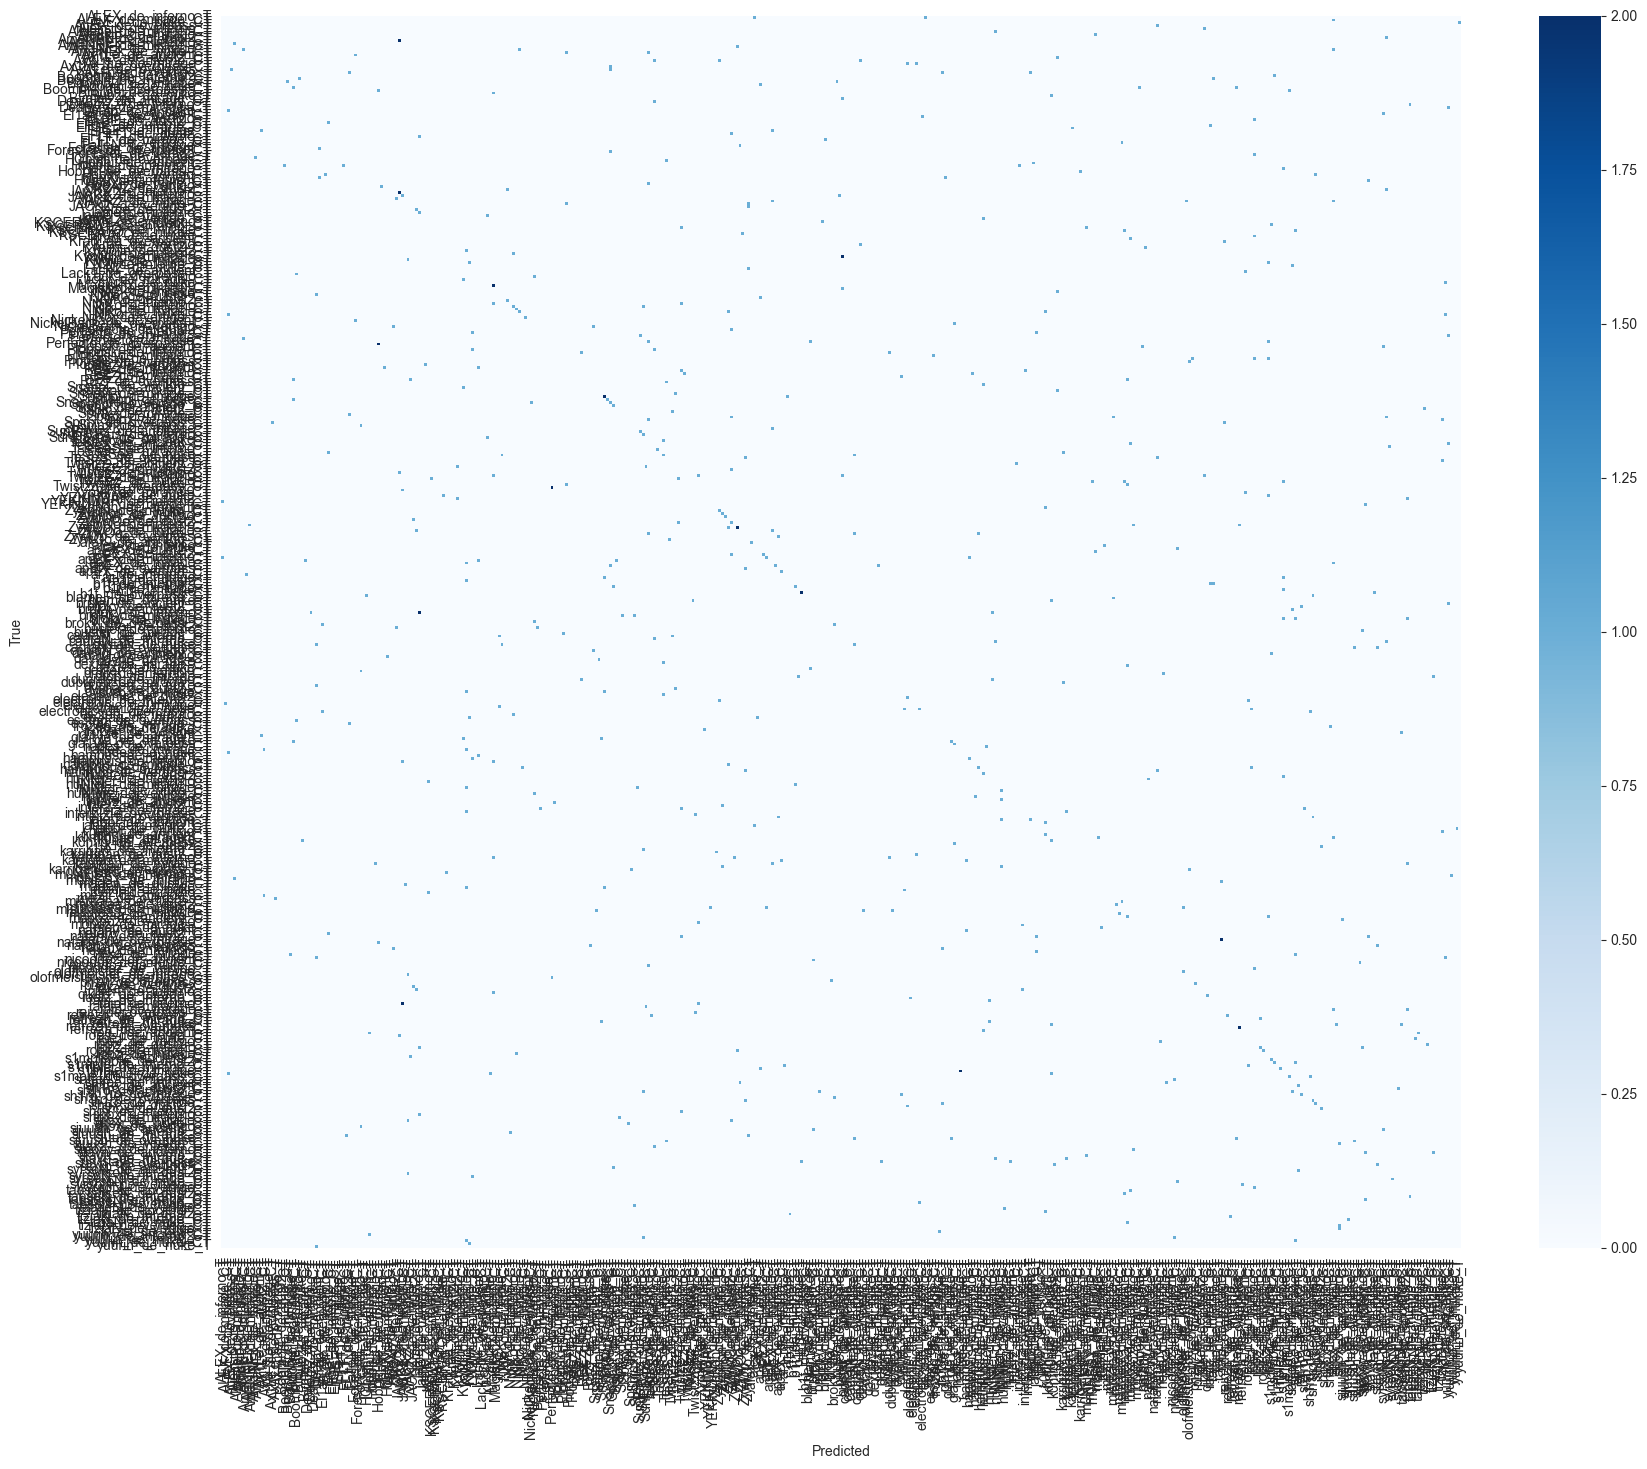

In [104]:
# === Configuration ===
save_figures = False
output_dir = "output_results"
os.makedirs(output_dir, exist_ok=True)

# === Helpers ===
def show_and_save(fig, filename):
    plt.tight_layout()
    if save_figures:
        fig.savefig(os.path.join(output_dir, filename), dpi=150)
    plt.show()
    plt.close(fig)

def show_and_save_conf_matrix(cm, labels, title, filename):
    fig, ax = plt.subplots(figsize=(8, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(include_values=True, cmap='Blues', ax=ax, xticks_rotation='vertical')
    ax.set_title(title)
    show_and_save(fig, filename)

half_metrics = [
    'ch_area', 'ch_volume', 'ch_area_normed', 'ch_volume_normed',
    'frac_dim',
    'C1', 'C2', 'C3', 'C4', 'C5',
    'alpha_d', 'alpha_j', 'num_samples_d', 'num_samples_j',
]

players = ['p1', 'p2', 'p3', 'p4', 'p5']

X_all = []
y_all = []

for player in players:
    player_features = [f"{player}_{metric}" for metric in half_metrics[:-2]]
    X_player = test_df[player_features].to_numpy()

    # Create label as concatenated string
    y_player = [
        f"{name}_{map_name}_{side}"
        for name, map_name, side in zip(
            test_df[f'{player}_name'],
            test_df['mapName'],
            test_df['side']
        )
    ]

    # Keep only labels that appear at least 5 times globally
    value_counts = pd.Series(y_player).value_counts()
    valid_labels = set(value_counts[value_counts >= 5].index)

    mask = [label in valid_labels for label in y_player]

    if sum(mask) == 0:
        continue

    X_all.append(X_player[mask])
    y_all.append([label for label, m in zip(y_player, mask) if m])

# Stack features
X = np.vstack(X_all)
# Flatten labels into a single list
y = [label for sublist in y_all for label in sublist]

# Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)

print(f'{le.classes_.shape} classes')

# Split, scale, train, and evaluate as before
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

log_reg = LogisticRegression(max_iter=1000, class_weight='balanced', C=1, random_state=42)
log_reg.fit(X_train, y_train)
y_pred = log_reg.predict(X_test)

train_acc = log_reg.score(X_train, y_train)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

print(f"Train Accuracy: {train_acc:.4f}")
print(f"Test Accuracy: {accuracy:.4f} | Precision: {precision:.4f} | Recall: {recall:.4f} | F1: {f1:.4f}")

coef_df = pd.DataFrame(log_reg.coef_, columns=half_metrics[:-2], index=le.classes_)
avg_abs_coef = coef_df.abs().mean(axis=0)
coef_ranking_df = avg_abs_coef.sort_values(ascending=False).reset_index()
coef_ranking_df.columns = ['Feature', 'AvgAbsCoefficient']
print(coef_ranking_df)

labels = le.classes_


cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(20, 16))
sns.heatmap(cm, cmap="Blues", xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()
